# Example calculation with AiiDA-Spirit

The main idea is that the AiiDA-Spirit plugin does the following steps for the users:
- take inputs: structure, list of couplings, parameters for the Spirit calculation (external field, temperature, ...) as AiiDA datatypes which are automatically stored in the AiiDA database to keep the provenance of calculations
- translate AiiDA datatypes into the proper format that spirit understands (i.e. create the spirit input configuration file)
- create a `run_spirit.py` file that runs a spirit calculation (i.e. using the spirit python API)
- submit running the `run_spirit.py` script on a node of a supercomputer, a workstation, etc (this takes care of creating a job submission script, connecting with ssh and retrieveing the outcome of the calculation to the AiiDA database and file repository for persistent storage)
-some parsing of the spirit output is done already which allows easy and fast access from the AiiDA database, this also makes results findabale (via SQL queries that can be done from AiiDA's python API without the need to know SQL commands)

These steps are demonstrated here with a simple example.

Before AiiDA can be used we need to connect to our AiiDA database:

In [1]:
from aiida import load_profile

load_profile()

# we also load some classes from the AiiDA package
from aiida.orm import StructureData, Dict, ArrayData, Code

# numpy for arrays
import numpy as np

# matplotlib for plotting
from matplotlib import pyplot as plt

Now we can continue setting up the AiiDA-Spirit calculation

## 1. prepare inputs (AiiDA database)

### Information of the crystal structure (AiiDA `StructureData` object)

In [2]:
# initialize the structure with the Bravais matrix (unit are in Angstroem!)
structure = StructureData(cell=[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

# add an atom (cartesian coordinates in Angstroem units)
# we need to put a symbol, although this is not needed used by the AiiDA-Spirit plugin
structure.append_atom(position = [0., 0., 0.], symbols='Fe')

### List of coupling parameters (Jijs, Dijs)

In [3]:
# prepare list of the couplings (usually this is done when parsing an output of an ab initio calculation)
jijs = np.array([
   # i, j, da, db, dc, Jij [, Dijx, Dijy, Dijz]
    [0, 0,  1,  0,  0, 10.0, 6.0, 0.0, 0.0], 
    [0, 0,  0,  1,  0, 10.0, 0.0, 6.0, 0.0], 
    [0, 0,  0,  0,  1, 10.0, 0.0, 0.0, 6.0], 
])

# to work with the couplings this needs to be an AiiDA datatype
# so far the AiiDA-Spirit plugin expects and array of the name 'Jij_expanded'
jij_data = ArrayData()
jij_data.set_array('Jij_expanded', jijs)

### Spirit-specific input parameters 

This can be used to control the spirit run (external field, number of unit cells in spirit simulation, perdiodic boundary conditions, ...).

Most parameters from the [spirit documentation can be set](https://spirit-docs.readthedocs.io/en/latest/core/docs/Input.html) except for some parameters that are automatically set.

In [4]:
# parameters that go into the spirit configuration file
input_para = {
        ### Hamiltonian
        # impurity spin moments in mu_Bohr
        'mu_s': [2.2], # list of spin moments, needed to apply an external field
        # Spirit supercell 
        'n_basis_cells': [10, 10, 10],
        # external magnetic field in T (point in +z direction)
        'external_field_magnitude': 0.5,
        'external_field_normal': [0.0, 0.0, 1.0],
        # single-ion anisotropy in meV
        'anisotropy_magnitude': 1.,
        'anisotropy_normal': [0.0, 0.0, 1.0],
        ### LLG settings
        'llg_n_iterations': 50000, 
        'llg_n_iterations_log': 1000, 
        'llg_temperature': 4,  # temperature noise (K)
        'llg_dt':  1.0E-3, # LLG time step (ps)
        'llg_force_convergence': 1e-7,
}
parameters = Dict(dict=input_para)

# run modes of spirit that go into the run_spirit.py script
run_opts = Dict(
    dict={
        'simulation_method': 'llg',
        'solver': 'depondt',
        'configuration': {'plus_z': True},
})

In [5]:
#set up a spirit calculations
from aiida.engine import submit
from aiida.plugins import CalculationFactory
builder = CalculationFactory('spirit').get_builder()

In [6]:
builder.structure = structure
builder.jij_data = jij_data
builder.parameters = parameters
builder.run_options = run_opts

# code and computer options (queue name etc.)
builder.code = Code.get_from_string('spirit@iffslurm')
builder.metadata.options = {
    'withmpi': False, # Spirit does not have MPI
    'resources': {'num_machines': 1, 'tot_num_mpiprocs': 1},
    'queue_name': 'oscar',  # use oscar partition
    'max_wallclock_seconds': 3600 # 1 h max runtime
}

builder.metadata.label = 'my-label'
builder.metadata.dry_run = True # just do a dry run to see what AiiDA-Spirit does under the hood

In [7]:
spirit_calc = submit(builder)
spirit_calc

<CalcJobNode: uuid: dd742d2c-2ab2-4f34-9980-b2a4894b80ed (pk: 29563) (aiida.calculations:spirit)>

### Now submit the calculation

Before we submit we should make sure that 

If the daemon is not running, make sure to start it:

Now we want to run the calculation (instead of doing the dry run as before). This actually submits the calculation to the daemon (which therefore needs to be running to submit it to the cluster).

In [8]:
builder.metadata.dry_run = False # now do a proper run

spirit_calc = submit(builder)
spirit_calc

<CalcJobNode: uuid: e5013f79-40b4-47da-9a81-fd10fa29bd95 (pk: 29564) (aiida.calculations:spirit)>

This job runs for ~ 1 min on the cluster (+ some time for copying files back and forth). 


You can check on the status of the job (in the terminal) with 
```
verdi process report <pk>
```
or
```
verdi process status <pk>
```
where `<pk>` is the identifier of the calculation. A list of the currently running calculations can be shown with 
```
verdi process list

   PK  Created    Process label      Process State    Process status
-----  ---------  -----------------  ---------------  ------------------------------------------------------------------------------------
29564  13s ago    SpiritCalculation  ⏵ Waiting        Waiting for transport task: upload
```

Further, with
```
verdi calcjob gotocomputer <pk>
```
you can go to the directory where the calcualtion runs (i.e. this opens an ssh connection to the cluster).

> **Note:**
> Of course you can also load an old calculation at a later point. For that you can use the `aiida.orm.load_node` command. Using `aiida.orm.Groups` is also a good idea to organize calculations.

From the python API we can also check on the status of the process and check the exit status of the process:

In [9]:
spirit_calc.process_state, spirit_calc.exit_status, spirit_calc.exit_message

(<ProcessState.FINISHED: 'finished'>, 0, None)

In [10]:
list(spirit_calc.outputs)

['energies',
 'magnetization',
 'output_parameters',
 'remote_folder',
 'retrieved']

When the calculation is done we can check the outcome of the calculation. These are the output nodes of the calculation
* `remote_folder` is a link to the working directory on iffslurm, this can be deleted and is not guaranteed to be persistent
* `retrieved` is the folder in the AiiDA repository where some output files of the spirit run are copied to (this is persistent)
* `outputs_parameters` is a `Dict` node that contains some values parsed from the spirit output (total runtime, iterations per second, ...)
* `magnetization` is an `ArrayData` that contains both initial and final directions of the spins
* `energies` is an `ArrayData` which contains the list of energies that is parsed in the calculation

These files are retrieved and thus persistently stored in the file repository:

In [11]:
spirit_calc.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'input_created.cfg',
 'run_spirit.py',
 'spirit.stdout',
 'spirit_Image-00_Energy-archive.txt',
 'spirit_Image-00_Spins-final.ovf',
 'spirit_Image-00_Spins-initial.ovf']

These values are parsed from the spirit output:

In [12]:
spirit_calc.outputs.output_parameters.get_dict()

{'solver': 'Depondt',
 'runtime': '0:1:4.721',
 'it_per_s': 684.77,
 'num_errors': 0,
 'runtime_sec': 64.721,
 'num_warnings': 0,
 'simulation_mode': 'LLG',
 'simulation_time': 1.002,
 'simulation_time_unit': 'ps'}

We now access the output energies and plot them:

In [13]:
# get name of the array
spirit_calc.outputs.energies.get_arraynames()

['energies']

In [14]:
# load the data (i.e. a numpy array)
e = spirit_calc.outputs.energies.get_array('energies')

This is how we can access files in the repository (here to find the labels of the columns of the energies):

In [15]:
with spirit_calc.outputs.retrieved.open('spirit_Image-00_Energy-archive.txt') as _f:
    e_header = _f.read().split('\n')[0].split()
e_header

['iteration', 'E_tot', 'Zeeman', 'Anisotropy', 'Exchange', 'DMI']

Now we plot the energies and their convergence:

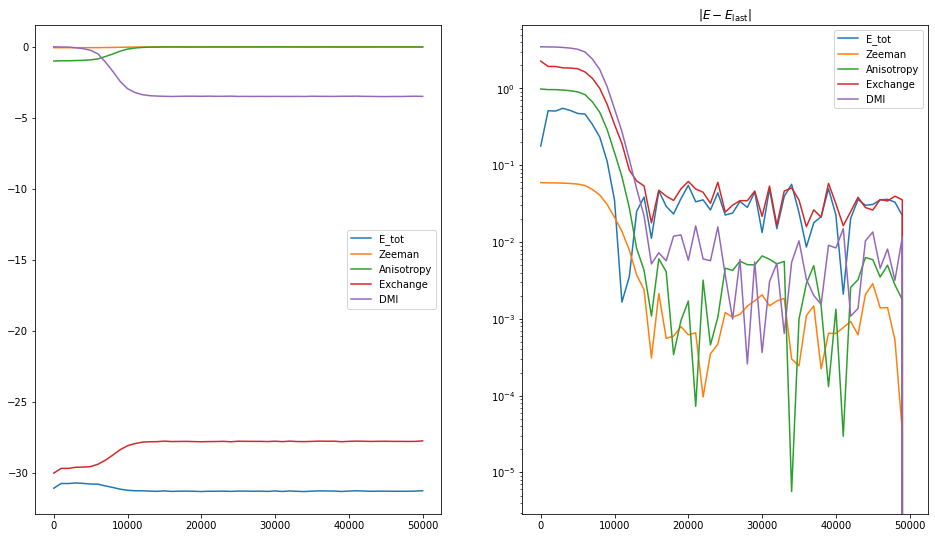

In [16]:
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
for i, label in enumerate(e_header[1:]):
    plt.plot(e[:,0], e[:,1+i], label=label)
plt.legend()

plt.subplot(1,2,2)
for i, label in enumerate(e_header[1:]):
    plt.plot(e[:,0], abs(e[:,1+i]-e[-1,1+i]), label=label)
plt.legend()
plt.yscale('log')
plt.title('$|E - E_{\mathrm{last}}|$')

plt.show()

We can also investigate the magnetization

In [17]:
m = spirit_calc.outputs.magnetization

In [18]:
m.get_arraynames()

['final', 'initial']

In [19]:
m_f = m.get_array('final')

In [20]:
m_f.mean(axis=0)

array([0.00262255, 0.00372453, 0.06476631])

In [21]:
m_f.std(axis=0)

array([0.69847005, 0.70429553, 0.1090503 ])

In [22]:
m_f.min(axis=0)

array([-0.99992973, -0.99989183, -0.26250733])

In [23]:
m_f.max(axis=0)

array([0.99988842, 0.9997142 , 0.36336339])

Or we copy the used input file and the magnetization configuration back (this allows to easily download the files and plot them in the Spirit gui):

In [24]:
for fname in ['spirit_Image-00_Spins-final.ovf', 'input_created.cfg'] :
    with spirit_calc.outputs.retrieved.open(fname) as _fin:
        with open(fname, 'w') as _fout:
            # write from retrieved to current dir
            _fout.writelines(_fin.readlines())

```
path-to-spirit/spirit -f input_created.cfg -i spirit_Image-00_Spins-final.ovf
```

<img src="spirit-gui-screenshot.png" alt="" width="1200"/>